# Problem 6 - Phase Identification(2)

## Agenda
- Problem Description
- Problem Implementation
- Wrap-Up

## Problem Description
- <b>Consider $N$ customers whose connection phase assumes one out of three possible labels $a$, $b$, or $c$ and estimate the correct customer-to-label assignment based on $M$ readings whose per-phase values are a function of the corresponding phase-connected individual customer reading.

Considered network
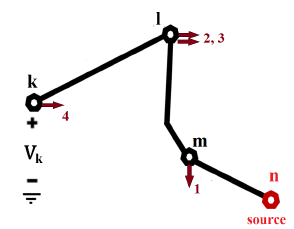

<b>Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

Parameters

In [2]:
cosPhi=0.95
time=48
m=12
netFactor=0.25
noiseFactor=0.00

<b>Initial data

In [3]:
#Consumption dataset
s=  [[0.0450,    0.0150,    0.0470,    0.0330],
     [0.0250,    0.0150,    0.2480,    0.0330],
     [0.0970,    0.0250,    0.3940,    0.0330],
     [0.0700,    0.0490,    0.0200,    0.4850],
     [0.1250,    0.0460,    0.0160,    0.1430],
     [0.2900,    0.0270,    0.0160,    0.0470],
     [0.2590,    0.0150,    0.0170,    0.0200],
     [0.2590,    0.0160,    0.0280,    0.0160],
     [0.4420,    0.0160,    0.0500,    0.0170],
     [0.2010,    0.0230,    0.0460,    0.0160],
     [0.2060,    0.0490,    0.0220,    0.0240],
     [0.1300,    0.0470,    0.0160,    0.0490],
     [0.0460,    0.0260,    0.0170,    0.0480]]
s = np.array(s)

#topology
topo=[[1, 2],[2,3],[3,4]]
nBUS=np.max(topo)

#Impedance
z=np.multiply([complex(0.1,0.05),complex(0.15,0.07),complex(0.2,0.1)],netFactor)

vr=1 #Reference voltage
el=1
ni=20 #Iterations for the Power Flow


print(z)

[0.025 +0.0125j 0.0375+0.0175j 0.05  +0.025j ]


<b>Power Flow Function

In [4]:
def pf3ph(t,z,si,vr,el,ni,al):
    #Matrices creation
    t=np.array(t)
    p=t[:,0]
    f=t[:,1]
    w=len(p)+1
    vp=np.zeros((nBUS-1,w), dtype=complex)
    vn=np.zeros((nBUS-1,w), dtype=complex)
    vp[0,0:w]=vr
    
    for h in range (2,nBUS):
        vp[h-1,:]=vp[h-2,:]*al  #Create a three phase system of voltages
                                #Voltages will be the same in all BUS

    va=vp-vn                                                      #Auxiliar voltage
    ia=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))      #Auxiliar current 
    
    for it in range(ni):                                          #Iterations of Power Flow
        va=vp-vn
        ip=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))  #Phase current 
        inn=-np.sum(ip,0)                                         #Neutral current 
        for k in range(w-1,0,-1):                                 #Backward Cycle
            n=f[k-1]
            m=p[k-1]
            ip[:,m-1]=ip[:,m-1]+ip[:,n-1]                         #Phase Current
            inn=-np.sum(ip,0)                                     #Neutral Current

        eps= np.linalg.norm(np.max(np.abs(ia-ip),0))              #Error, comparing the new currents and the old ones (previous iteration)

        if eps>1e-4:
            ia=ip
            mvp=0
            mvn=0
            eps=np.inf
        else:                       #If the error is lower than the limit, we can return the results 
            mvp=(vp-vn)             #Phase Voltages to return
            mvn=vn[0,:]             #Neutral Voltage to return
#            return mvp, mvn, eps, ip, inn;
            return mvp;
        for k in range (w-1):                     #Forward Cycle
            n=f[k]                                
            m=p[k]
            vn[:,n-1]=vn[:,m-1]-z[k]*inn[n-1]     #Neutral Voltage 
            vp[:,n-1]=vp[:,m-1]-z[k]*ip[:,n-1]    #Phase Voltage
        ia=ip             #Save the current of previous iteration


<b> Compute the values of voltages obtained by PMUs

In [5]:
#Creation of Matrices
al=np.exp(np.multiply(np.multiply(complex(0,-1),2/3),np.pi)) #Phase Angle
Y=np.zeros((3*m), dtype=complex)
X=np.zeros((3*m,m), dtype=complex)
v=np.zeros((m,3))
dv_abs=np.zeros((m,3))


for i in range(m):
    si=[[0, 0, s[i,2], 0],[0, 0, s[i,1], 0],[0, s[i,0],  0, s[i,3]]] #Connection of consumers by
                                                                     #node and by phase
                                                                     #Consumer 1 (s[i,0]) is 
                                                                     #connected to Bus 2 in Phase 3
    mvp=pf3ph(topo,z,si,vr,el,ni,al)
    noise=1+noiseFactor*np.random.randn(3)
    mvp[:,3]=np.multiply(mvp[:,3],noise)                       #Add noise to the voltages
    Y[3*(i):3*(i)+3]=mvp[:,3]                                  #Save the voltages in matrix Y
    dv_abs[i,:]=vr-np.abs(mvp[:,3])                            #Volage variations (only to plot)

Volt=np.reshape(Y,(m,3))   

print ('The voltages measured in the PMUs are:\n',Volt)

The voltages measured in the PMUs are:
 [[ 0.99866484-0.00476962j -0.49831414-0.86835917j -0.49392011+0.85964588j]
 [ 0.97290228-0.01601085j -0.51139766-0.87380016j -0.50744349+0.85456696j]
 [ 0.95608633-0.02441701j -0.51885398-0.87750207j -0.51325967+0.84910673j]
 [ 1.04767033-0.03551787j -0.45091668-0.89757332j -0.40102796+0.79332501j]
 [ 1.01576499-0.00999985j -0.48302166-0.87236861j -0.46567302+0.84426734j]
 [ 1.00968654-0.00695356j -0.48918564-0.87063669j -0.47774451+0.85167455j]
 [ 1.00602188-0.005418j   -0.49284148-0.869901j   -0.48483326+0.85566688j]
 [ 1.00423842-0.00571336j -0.4939299 -0.86980129j -0.48633757+0.85598497j]
 [ 1.00578779-0.00995392j -0.4910006 -0.87340185j -0.4790803 +0.84942259j]
 [ 1.0006834 -0.00538471j -0.49631931-0.86845387j -0.49010362+0.8577634j ]
 [ 1.00475844-0.00282624j -0.4936193 -0.86480633j -0.48660002+0.8589564j ]
 [ 1.00631448-0.00319825j -0.49244873-0.86549546j -0.48460471+0.85781421j]]


<b> Sum of Impedences
    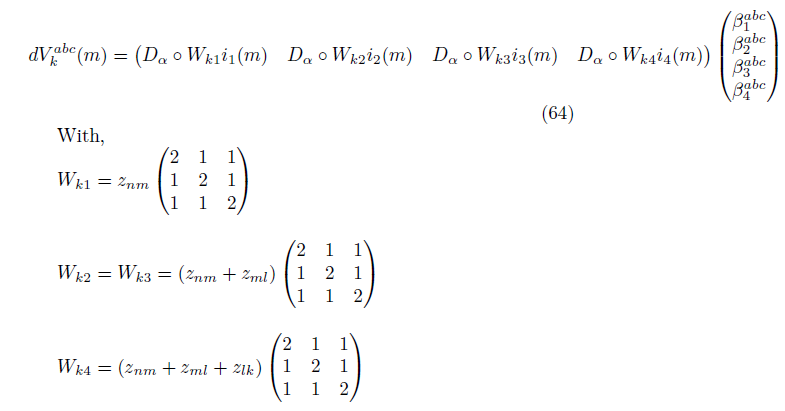

In [6]:
#The value of Z is the multiplication between D and W but not considering the values of z_nm;z_ml and zlk

Z=[[2, al, al**2],[1, 2*al, al**2],[1, al, 2*al**2]]
print ('Z:\n',Z)

Z:
 [[2, (-0.4999999999999998-0.8660254037844388j), (-0.5000000000000006+0.8660254037844385j)], [1, (-0.9999999999999996-1.7320508075688776j), (-0.5000000000000006+0.8660254037844385j)], [1, (-0.4999999999999998-0.8660254037844388j), (-1.000000000000001+1.732050807568877j)]]


In [7]:
Z1=np.zeros((1,3))
Z1=np.array([Z[0],Z[1],Z[2]])

print('Z:\n',Z)
print('\nZ1:\n',Z1)

#Values of z_nm;z_ml and zlk
print('\nz:\n',z)
print('\nznm:\n',z[0])
print('\nzml:\n',z[1])
print('\nzlk:\n',z[2])

#Calculating the multiplication between D and W considering the values of z_nm;z_ml and zlk (Eq. 64)
DoW1=np.zeros((3,3), dtype=complex)
DoW1=z[0]*Z1
DoW2=np.zeros((3,3), dtype=complex)
DoW2=(z[0]+z[1])*Z1
DoW3=np.zeros((3,3), dtype=complex)
DoW3=DoW2
DoW4=np.zeros((3,3), dtype=complex)
DoW4=(z[0]+z[1]+z[2])*Z1
print('\nDoW1:\n',DoW1)
print('\nDoW2:\n',DoW2)
print('\nDoW3:\n',DoW3)
print('\nDoW4:\n',DoW4)

Z:
 [[2, (-0.4999999999999998-0.8660254037844388j), (-0.5000000000000006+0.8660254037844385j)], [1, (-0.9999999999999996-1.7320508075688776j), (-0.5000000000000006+0.8660254037844385j)], [1, (-0.4999999999999998-0.8660254037844388j), (-1.000000000000001+1.732050807568877j)]]

Z1:
 [[ 2. +0.j         -0.5-0.8660254j  -0.5+0.8660254j ]
 [ 1. +0.j         -1. -1.73205081j -0.5+0.8660254j ]
 [ 1. +0.j         -0.5-0.8660254j  -1. +1.73205081j]]

z:
 [0.025 +0.0125j 0.0375+0.0175j 0.05  +0.025j ]

znm:
 (0.025+0.0125j)

zml:
 (0.0375+0.0175j)

zlk:
 (0.05+0.025j)

DoW1:
 [[ 0.05      +0.025j      -0.00167468-0.02790064j -0.02332532+0.01540064j]
 [ 0.025     +0.0125j     -0.00334936-0.05580127j -0.02332532+0.01540064j]
 [ 0.025     +0.0125j     -0.00167468-0.02790064j -0.04665064+0.03080127j]]

DoW2:
 [[ 0.125     +0.06j       -0.00526924-0.06912659j -0.05723076+0.03912659j]
 [ 0.0625    +0.03j       -0.01053848-0.13825318j -0.05723076+0.03912659j]
 [ 0.0625    +0.03j       -0.00526924-0.069

<b>Complex Expansion
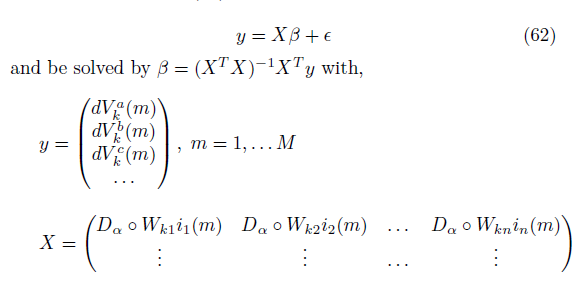

In [8]:
# Matrices CReation
vz=np.zeros(3*m, dtype=complex)
vz_abs=np.zeros(3*m, dtype=complex)

#Compute dVk for each time period m   
for i in range (m):
    vz[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    vz_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info
    
#Compute X matrix considering different W (Please use the value Z)
#Multiplication of DoW with the current (for m measurements)
for i in range(m):
      X[3*i:3*i+3,0:3]=np.dot(DoW1, s[i,0])
      X[3*i:3*i+3,3:6]=np.dot(DoW2, s[i,1])
      X[3*i:3*i+3,6:9]=np.dot(DoW3, s[i,2])
      X[3*i:3*i+3,9:12]=np.dot(DoW4, s[i,3])

#print(X)
#   Calculating the (X'X)^-1
X_t = np.transpose(X)
temp = np.linalg.inv(np.matmul(X_t, X))

#   Calculating ( (X'X)^-1 ) X' * Y
Bpmu = np.matmul(np.matmul(temp, X_t), vz)     #Betas with PMUs info

#   Calculating ( (X'X)^-1 ) X' * Y
Brtu = np.matmul(np.matmul(temp, X_t), vz_abs)     #Betas with RTUs info

print('\nBetas (complex) considering information from PMUs\n',Bpmu,'\n')
print('\nBetas (complex) considering information from RTUs\n',Brtu,'\n')

BBpmu=Bpmu.real
BBrtu=Brtu.real

print('\nBetas considering information from PMUs\n',BBpmu,'\n')
print('\nBetas considering information from RTUs\n',BBrtu,'\n')


Betas (complex) considering information from PMUs
 [ 8.48911918e-05+0.00267591j  8.94505723e-06+0.00087075j
  9.99814476e-01-0.01316107j  6.53417371e-05+0.00639303j
  1.00006576e+00+0.00013459j  3.17600231e-03+0.12282283j
  9.99748077e-01-0.02222942j -2.17365356e-06-0.00108381j
 -3.89139777e-05+0.00779855j -4.46213141e-06-0.00031504j
 -1.75636093e-05+0.00173224j  9.98299908e-01-0.06083752j] 


Betas (complex) considering information from RTUs
 [-0.54691574-0.18190167j  0.30851159+0.48237617j  1.03295766-0.69775125j
  0.31034131+0.5394602j   1.16243864-0.73869221j -0.5802952 -0.22916067j
  1.05334089-0.67256294j -0.53183608-0.20467905j  0.2838925 +0.49065128j
 -0.54323727-0.21232642j  0.25524374+0.50777213j  1.05809936-0.67194189j] 


Betas considering information from PMUs
 [ 8.48911918e-05  8.94505723e-06  9.99814476e-01  6.53417371e-05
  1.00006576e+00  3.17600231e-03  9.99748077e-01 -2.17365356e-06
 -3.89139777e-05 -4.46213141e-06 -1.75636093e-05  9.98299908e-01] 


Betas consideri

<b>Graphics

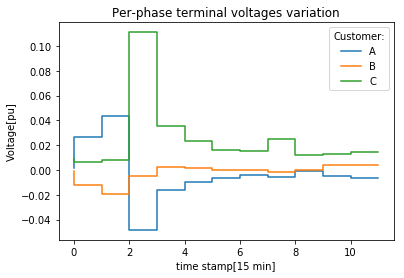

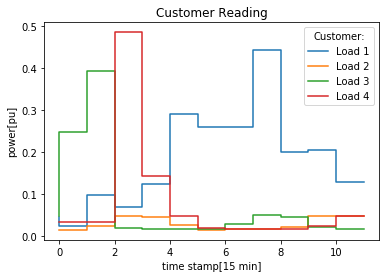

In [9]:
x = np.arange(m)
y1=dv_abs
y2=s[0:12,:]

#Graph 1
#Plot of the Per-phase terminal
y_array=y1[0:12,0]
y_array= np.reshape(y_array,(12,1))
plt.step(np.transpose(x), y_array, label='A')
y_array=y1[0:12,1]
y_array= np.reshape(y_array,(12,1))
plt.step(np.transpose(x), y_array, label='B')
y_array=y1[0:12,2]
y_array= np.reshape(y_array,(12,1))
plt.step(np.transpose(x), y_array, label='C')
plt.legend(title='Customer:')
plt.xlabel('time stamp[15 min]')
plt.ylabel('Voltage[pu]')
plt.title('Per-phase terminal voltages variation')
plt.show()

#Graph 2
#Plot of Consumers Readings
y_array=s[0:12,0]
y_array= np.reshape(y_array,(12,1))
plt.step(np.transpose(x), y_array, label='Load 1')
y_array=s[0:12,1]
y_array= np.reshape(y_array,(12,1))
plt.step(np.transpose(x), y_array, label='Load 2')
y_array=s[0:12,2]
y_array= np.reshape(y_array,(12,1))
plt.step(np.transpose(x), y_array, label='Load 3')
y_array=s[0:12,3]
y_array= np.reshape(y_array,(12,1))
plt.step(np.transpose(x), y_array, label='Load 4')
plt.legend(title='Customer:')
plt.xlabel('time stamp[15 min]')
plt.ylabel('power[pu]')
plt.title('Customer Reading')
plt.show()

In [179]:
# For Bpmu
# Not knowing the values of the line impedances (z_nm, z_ml, z_lk)
# Calculating the multiplication between D and W considering the values of Bpmu calculated in the previous submission
DoW1=np.zeros((3,3), dtype=complex)
DoW1=Bpmu[0:3]*Z1
DoW2=np.zeros((3,3), dtype=complex)
DoW2=Bpmu[3:6]*Z1
DoW3=np.zeros((3,3), dtype=complex)
DoW3=Bpmu[6:9]*Z1
DoW4=np.zeros((3,3), dtype=complex)
DoW4=Bpmu[9:12]*Z1

# Matrices Creation
vz=np.zeros(3*m, dtype=complex)
vz_abs=np.zeros(3*m, dtype=complex)

# Compute dVk for each time period m   
for i in range (m):
    vz[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    vz_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info

# Multiplication of DoW with the current (for m measurements)
for i in range(m):
      X[3*i:3*i+3,0:3]=np.dot(DoW1, s[i,0])
      X[3*i:3*i+3,3:6]=np.dot(DoW2, s[i,1])
      X[3*i:3*i+3,6:9]=np.dot(DoW3, s[i,2])
      X[3*i:3*i+3,9:12]=np.dot(DoW4, s[i,3])

# Calculating the (X'X)^-1
X_t = np.transpose(X)
temp = np.linalg.inv(np.matmul(X_t, X))

# Calculating ( (X'X)^-1 ) X' * Y that will give us z
z = np.matmul(np.matmul(temp, X_t), vz)

# z[3:9] is the sum of z_nm and z_ml, so we needed to subtract the value of z_nm
z[3:9]=z[6]-z[0]

# z[9:12] is the sum of z_nm, z_ml and z_lk, so we needed to subtract the values of z_nm and z_ml
z[9:12]=z[-1]-z[7]-z[0]

print('For Bpmu:')
print('\nTo calculate the impedances line we used the same formula seen in Eq. 62, but this time we used the values of Bpmu instead of the z_nm, z_ml and z_lk, obtaining the following values for the impedances:')
print('\nz_nm:\n', np.round(z[0],5), '\n\nz_ml:\n', np.round(z[6],5),'\n\nz_lk:\n', np.round(z[10],5))



# For Brtu
# Calculating the multiplication between D and W considering the values of Brtu calculated in the previous submission

DoW1=Brtu[0:3]*Z1
DoW2=Brtu[3:6]*Z1
DoW3=Brtu[6:9]*Z1
DoW4=Brtu[9:12]*Z1

# Matrices Creation
vz=np.zeros(3*m, dtype=complex)
vz_abs=np.zeros(3*m, dtype=complex)

# Compute dVk for each time period m   
for i in range (m):
    vz[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    vz_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info
    
# Multiplication of DoW with the current (for m measurements)
for i in range(m):
      X[3*i:3*i+3,0:3]=np.dot(DoW1, s[i,0])
      X[3*i:3*i+3,3:6]=np.dot(DoW2, s[i,1])
      X[3*i:3*i+3,6:9]=np.dot(DoW3, s[i,2])
      X[3*i:3*i+3,9:12]=np.dot(DoW4, s[i,3])

# Calculating the (X'X)^-1
X_t = np.transpose(X)
temp = np.linalg.inv(np.matmul(X_t, X))

# Calculating ( (X'X)^-1 ) X' * Y that will give us z
z = np.matmul(np.matmul(temp, X_t), vz_abs)

# z[3:9] is the sum of z_nm and z_ml, so we needed to subtract the value of z_nm
z[3:9]=z[6]-z[0]

# z[9:12] is the sum of z_nm, z_ml and z_lk, so we needed to subtract the values of z_nm and z_ml
z[9:12]=z[-1]-z[7]-z[0]

print('\n\n\nFor Brtu:')
print('\nTo calculate the impedances line we used the same formula seen in Eq. 62, but this time we used the values of Brtu instead of the z_nm, z_ml and z_lk, obtaining the following values for the impedances:')
print('\nz_nm:\n', np.round(z[0],5), '\n\nz_ml:\n', np.round(z[6],5),'\n\nz_lk:\n', np.round(z[10],5))

For Bpmu:

To calculate the impedances line we used the same formula seen in Eq. 62, but this time we used the values of Bpmu instead of the z_nm, z_ml and z_lk, obtaining the following values for the impedances:

z_nm:
 (0.025+0.0125j) 

z_ml:
 (0.0375+0.0175j) 

z_lk:
 (0.05+0.025j)



For Brtu:

To calculate the impedances line we used the same formula seen in Eq. 62, but this time we used the values of Brtu instead of the z_nm, z_ml and z_lk, obtaining the following values for the impedances:

z_nm:
 (0.025+0.0125j) 

z_ml:
 (0.0375+0.0175j) 

z_lk:
 (0.05+0.025j)
